In [1]:
"""Importowanie potrzebnych w projekcie bibliotek"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# LAB 3 - Ekstrakcja podstawowych parametrów geometrycznych na obrazach binarnych

In [2]:
"""Definicja klasy ImageToAnalyse wraz z metodami służącymi do operacji na obrazie wejściowym"""
class ImagesToAnalyse:
    
    """Knstruktor klasy ImagesToAnalyse wywołuje metody zadeklarowane poniżej i przypisuje zwrócone wartości do odpowiednich pól obiektu"""
    def __init__(self, imSrc):
        self.sourceImage = imSrc
        self.grayImage = self.makeImageGray()
        self.binImage = self.makeImageBin()
        self.EdgeClear = self.clear(self.binImage)
        self.ObjectFill = self.fill(self.EdgeClear)
        (self.numberOfElements, self.labeledArray) = self.bwlabel()
    
    """Metoda makeImageGray służy to konwersji obrazu wejściowego do skali szarości"""
    def makeImageGray(self):
        return cv2.cvtColor(self.sourceImage, cv2.COLOR_BGR2GRAY)

    """Metoda makeImageBin służy do konwersji obrazu ze skali szarości do obrazu binarnego"""
    def makeImageBin(self):
        (tmp_thresh, tmp_bin) = cv2.threshold(self.grayImage, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        return tmp_bin

    """Metoda areaOfObject służy obliczenia pola powierzchni badanego obiektu (albo cały obraz albo pojedyńczy obiekt na obrazie jeśli podstawiony został jako obraz wejściowy)"""
    def areaOfObject(self, objectToCalc):
        return np.count_nonzero(objectToCalc)

    """Implemetacja matlabowej metody bwlabel - zwraca liczbę obiektów na obrazie oraz obraz z indeksami poszczególnych elementów"""
    def bwlabel(self):
        srcImage = self.EdgeClear
        (numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(srcImage)
        countLabels = np.count_nonzero(np.unique(labels))
        return countLabels, labels
    
    """Zwraca obraz zawierający element o wskazanym ID - przykładowo jeśli po indeksacji pojawiają się dwa elementy, a user podał ID=1 to zwróci element numer 1"""
    def getElementWithId(self, IDofEL):
        return (self.labeledArray == IDofEL) * 1

    """Metoda fill odpowiedzialna jest za wypełnienie dziór w elementach na obrazie binarnym"""
    def fill(self, srcImage):
        negateImg = np.invert(srcImage)
        clearedInv = self.clear(negateImg)
        filledResult = cv2.bitwise_or(srcImage, clearedInv)
        return filledResult

    """Metoda clear odpowiedzialna jest za czyszczenie krawędzi obrazu binarnego - usuwane są elementy styczne z krawędziami"""
    def clear(self, srcImage):
        kernel = np.ones((3, 3), np.uint8)
        base = srcImage.copy()
        [dx, dy] = base.shape
        operator = base.copy()
        operator[1:dx - 1, 1:dy - 1] = 0

        while True:
            oldOperator = operator.copy()
            operator = cv2.dilate(operator, kernel, iterations=1)
            operator = cv2.bitwise_and(operator, base)

            if (np.array_equal(operator, oldOperator)):
                result = operator
                break

        cleared = cv2.bitwise_xor(result, srcImage)
        return cleared
    
    """Metoda realizująca odnalezienie punktu startowego dla metody FreemanChainCode"""
    def getStartPos(self, srcImage):
        for i in range(srcImage.shape[0]):
            for j in range(srcImage.shape[1]):
                getVal = srcImage[i,j]
                if(0 < getVal):
                    startPosition = (i, j)
                    return startPosition

    """Metoda realizująca obliczenie obwodu badanej figury przy pomocy FCC (FreemanChainCode). Zwracana jest liczba całkowita oraz liczba pierwiastków z 2"""
    def FreemanChainCode(self, srcImage):
        directions = [  5,  6,  7,
                        4,      0,
                        3,  2,  1]
        
        change_j =   [  -1,  0,  1,
                        -1,      1,
                        -1,  0,  1]
        
        change_i =   [  -1, -1, -1,
                         0,      0,
                         1,  1,  1]
        
        dir2idx = dict(zip(directions, range(len(directions))))

        start_point = self.getStartPos(srcImage)
        curr_point = start_point
        border = []
        chain = []

        for direction in directions:
            idx = dir2idx[direction]
            new_point = (start_point[0]+change_i[idx], start_point[1]+change_j[idx])
            if srcImage[new_point] != 0: # if is ROI
                border.append(new_point)
                chain.append(direction)
                curr_point = new_point
                break

        count = 0
        while curr_point != start_point:
            b_direction = (direction + 5) % 8 
            dirs_1 = range(b_direction, 8)
            dirs_2 = range(0, b_direction)
            dirs = []
            dirs.extend(dirs_1)
            dirs.extend(dirs_2)
            for direction in dirs:
                idx = dir2idx[direction]
                new_point = (curr_point[0]+change_i[idx], curr_point[1]+change_j[idx])
                if srcImage[new_point] != 0: # if is ROI
                    border.append(new_point)
                    chain.append(direction)
                    curr_point = new_point
                    break
            if count == 1000: break
            count += 1

        straight_lines = [0, 2, 4, 6]
        straight_count = 0
        curve_count = 0

        for l in chain:
            if l in straight_lines:
                straight_count += 1
            else:
                curve_count += 1

        return straight_count, curve_count


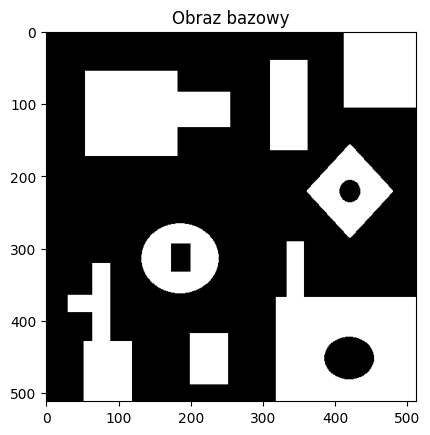

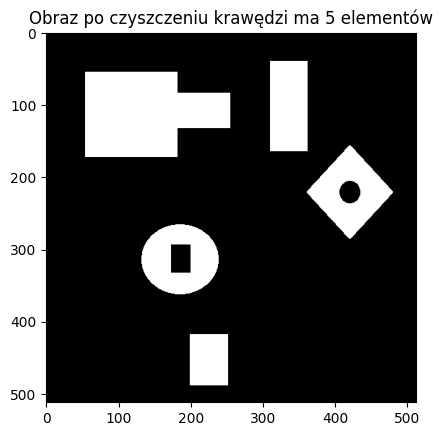

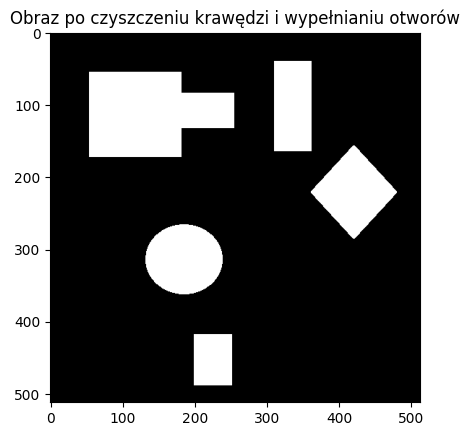

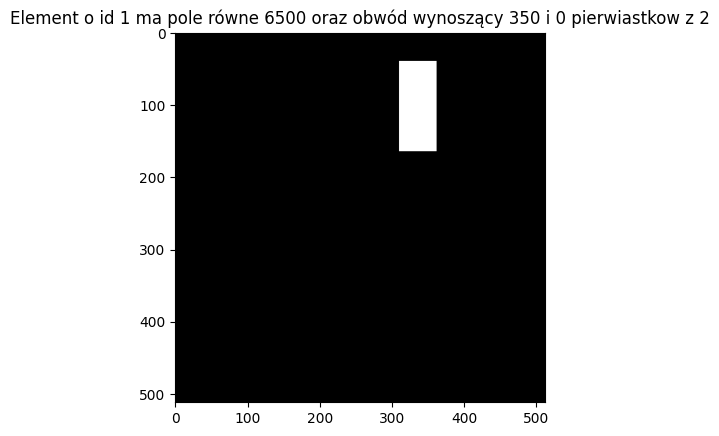

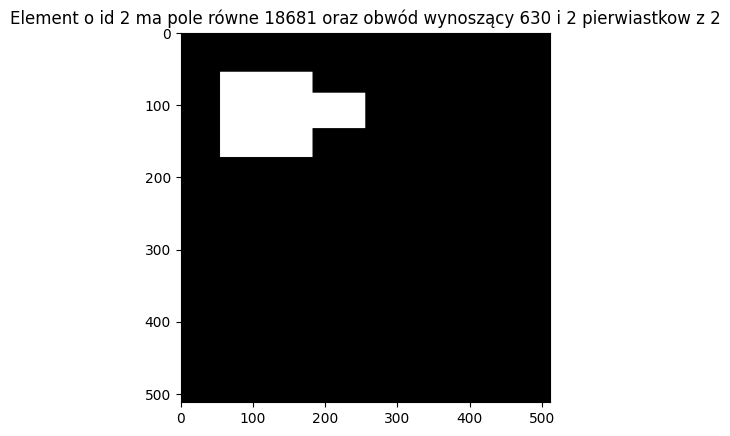

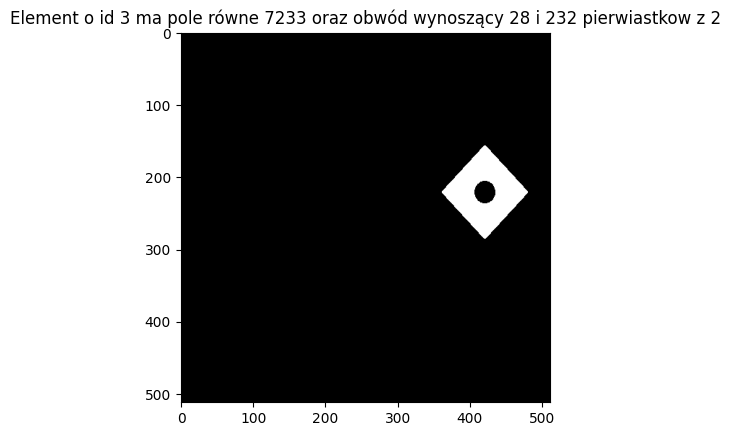

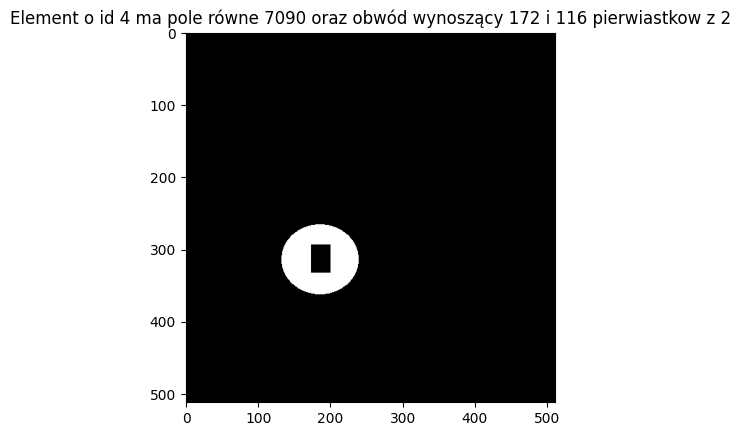

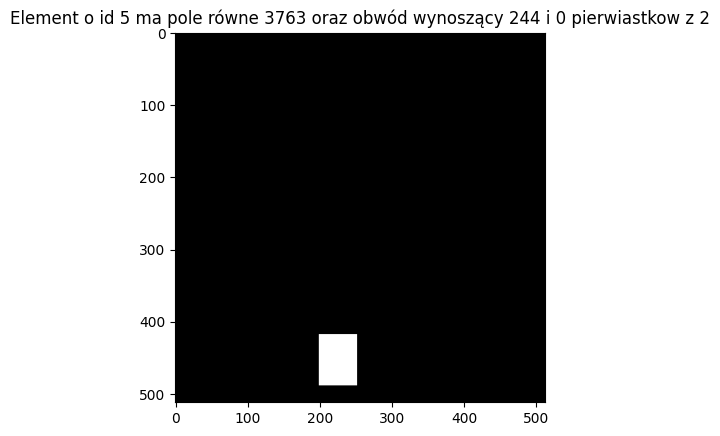

In [3]:
"""Utworzenie obiektu z klasy ImagesToAnalyse oraz wczytanie obrazu wejściowego"""
SourceImage = ImagesToAnalyse(cv2.imread("./SRC04.bmp"))

"""Wyświetlenie obrazu bazowego"""
plt.imshow(SourceImage.binImage, cmap='gray', vmin=0, vmax=255)
plt.title("Obraz bazowy")

"""Wyświetlenie obrazu po czyszczeniu krawędzi wraz z informacją o liczbie elementów na obrazie po czysczeniu"""
plt.figure()
plt.imshow(SourceImage.EdgeClear, cmap='gray', vmin=0, vmax=255)
plt.title("Obraz po czyszczeniu krawędzi ma " + str(str(SourceImage.numberOfElements)) + " elementów")

"""Wyświetlenie obrazu po czysczeniu krawędzi i wypełnianiu otworów"""
plt.figure()
plt.imshow(SourceImage.ObjectFill, cmap='gray', vmin=0, vmax=255)
plt.title("Obraz po czyszczeniu krawędzi i wypełnianiu otworów")

"""Wyświetlenie wszystkich elementów na obrazie po indeksacji oraz obliczenie ich pola powierzchni i obwodu (FCC)"""
for i in range(1, SourceImage.numberOfElements+1):
    Obwod_calkowite , Obwod_pierwiastek = SourceImage.FreemanChainCode(SourceImage.getElementWithId(i))
    plt.figure()
    plt.imshow(SourceImage.getElementWithId(i), cmap='gray', vmin=0, vmax=1)
    plt.title("Element o id " + str(i) + " ma pole równe " + str(SourceImage.areaOfObject(SourceImage.getElementWithId(i))) + " oraz obwód wynoszący " + str(Obwod_calkowite) + " i " + str(Obwod_pierwiastek) + " pierwiastkow z 2")